In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from rim import RIMNetwork
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# get the name of the tasks from the subfolder names
import os
folder = '../../training_data_reidar'
tasks_names = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
# we remove 'AntiCOMP2'
tasks_names = [task for task in tasks_names if task != 'AntiCOMP2']
tasks_names = np.sort(tasks_names)
print('number of tasks:', len(tasks_names))

number of tasks: 50


In [3]:
tasks_names

array(['AntiCOMP1', 'AntiDM', 'AntiDMMod1', 'AntiDMMod2', 'AntiDur1',
       'AntiDur2', 'AntiGo', 'AntiGoMod1', 'AntiGoMod2', 'AntiMultiCOMP1',
       'AntiMultiCOMP2', 'AntiMultiDM', 'AntiMultiDur1', 'AntiMultiDur2',
       'AntiRTGo', 'AntiRTGoMod1', 'AntiRTGoMod2', 'COMP1', 'COMP1Mod1',
       'COMP1Mod2', 'COMP2', 'COMP2Mod1', 'COMP2Mod2', 'ConAntiDM',
       'ConDM', 'DM', 'DMC', 'DMMod1', 'DMMod2', 'DMS', 'DNMC', 'DNMS',
       'Dur1', 'Dur1Mod1', 'Dur1Mod2', 'Dur2', 'Dur2Mod1', 'Dur2Mod2',
       'Go', 'GoMod1', 'GoMod2', 'MultiCOMP1', 'MultiCOMP2', 'MultiDM',
       'MultiDur1', 'MultiDur2', 'RTGo', 'RTGoMod1', 'RTGoMod2',
       'training_data'], dtype='<U14')

In [8]:
# we start with the simple tasks
tasks_names = ['Go','AntiGo','RTGo','AntiRTGo',
               'AntiRTGoMod1','AntiRTGoMod2',
               'AntiGoMod1', 'AntiGoMod2',
                'GoMod1', 'GoMod2',
                'RTGoMod1', 'RTGoMod2']


tasks_names = ['Go','AntiGo','RTGo','AntiRTGo']

In [9]:
class MultitaskDataset(Dataset):
    def __init__(self, tasks_names, folder, specific_task=None):
        self.all_inputs = []
        self.all_masks = []
        self.all_targets = []
        self.all_task_ids = []
        
        for task_id, task_name in enumerate(tasks_names):
            # Skip if specific_task is set and doesn't match current task
            if specific_task is not None and task_name != specific_task:
                continue
                
            try:
                input_data = np.load(f'{folder}/{task_name}/input_data.npy')[:, ::5]
                masks_data = np.load(f'{folder}/{task_name}/masks_data.npy')[:, ::5]
                target_data = np.load(f'{folder}/{task_name}/target_data.npy')[:, ::5]
                
                task_identity = np.zeros(len(tasks_names))
                task_identity[task_id] = 1
                
                task_inputs = np.concatenate([
                    input_data,
                    np.tile(task_identity, (input_data.shape[0], input_data.shape[1], 1))
                ], axis=-1)
                
                self.all_inputs.append(task_inputs)
                self.all_masks.append(masks_data)
                self.all_targets.append(target_data)
                self.all_task_ids.extend([task_id] * len(input_data))
                
            except:
                print(f'Issue loading training data for task {task_name}')
                continue
        
        self.all_inputs = np.concatenate(self.all_inputs, axis=0)
        self.all_masks = np.concatenate(self.all_masks, axis=0)
        self.all_targets = np.concatenate(self.all_targets, axis=0)
        self.all_task_ids = np.array(self.all_task_ids)

    def __len__(self):
        return len(self.all_inputs)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.all_inputs[idx]).to(device),
            torch.FloatTensor(self.all_masks[idx]).to(device),
            torch.FloatTensor(self.all_targets[idx]).to(device),
            self.all_task_ids[idx]
        )

# Load the dataset
dataset = MultitaskDataset(tasks_names, folder)

In [10]:
input_size = dataset.all_inputs.shape[-1]  # Includes task identity vector
output_size = dataset.all_targets.shape[-1]
num_tasks = len(tasks_names)
batch_size = 64

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [11]:
hidden_size = 64
learning_rate = 0.001
num_epochs = 50
 
num_mechanisms = 2
key_size = 2
rank = 2
num_heads = 1

model = RIMNetwork(input_size, hidden_size, output_size, num_mechanisms=num_mechanisms,
                key_size=key_size, rank=rank, num_heads=num_heads).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 30753


In [ ]:
losss = []
loss_moving_average = 0
accs = []
accuracy_moving_average = 0
loss_criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):


    i_step = 0
    for inputs, masks, targets, task_ids in dataloader:

        i_step += 1

        outputs_total,_,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))
    
        labels = torch.argmax(targets.to(device)[:,-1:,:].reshape(-1,output_size),dim=1)

        criterion = nn.CrossEntropyLoss(ignore_index=0)
        loss = criterion(outputs_total[:,-1:,:].reshape(-1,output_size),labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i_step % 100 == 1:

            # loss moving average
            loss_moving_average = 0.9 * loss_moving_average + 0.1 * loss.item()
            losss.append(loss_moving_average)

            output_max = torch.argmax(outputs_total[:,-1:,:].reshape(-1,output_size),dim=1)
            labels = torch.argmax(targets.to(device)[:,-1:,:].reshape(-1,output_size),dim=1)
            accuracy = torch.sum((output_max==labels))/len(labels)
            accuracy_moving_average = 0.9 * accuracy_moving_average + 0.1 * accuracy.item()
            accs.append(accuracy_moving_average)
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i_step}], Loss: {loss_moving_average:.4f}, Accuracy: {accuracy_moving_average:.4f}')

/tmp/ipykernel_152988/3145533436.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs_total,_,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))


Epoch [1/50], Step [1], Loss: 0.3529, Accuracy: 0.0000
Epoch [1/50], Step [101], Loss: 0.5518, Accuracy: 0.0109
Epoch [1/50], Step [201], Loss: 0.6819, Accuracy: 0.0333
Epoch [1/50], Step [301], Loss: 0.7879, Accuracy: 0.0581
Epoch [1/50], Step [401], Loss: 0.8638, Accuracy: 0.0804
Epoch [1/50], Step [501], Loss: 0.9322, Accuracy: 0.1083
Epoch [1/50], Step [601], Loss: 0.9670, Accuracy: 0.1350
Epoch [2/50], Step [1], Loss: 1.0047, Accuracy: 0.1605
Epoch [2/50], Step [101], Loss: 1.0712, Accuracy: 0.1867
Epoch [2/50], Step [201], Loss: 1.0926, Accuracy: 0.2117
Epoch [2/50], Step [301], Loss: 1.1090, Accuracy: 0.2265
Epoch [2/50], Step [401], Loss: 1.1157, Accuracy: 0.2398
Epoch [2/50], Step [501], Loss: 1.1179, Accuracy: 0.2627
Epoch [2/50], Step [601], Loss: 1.1235, Accuracy: 0.2661
Epoch [3/50], Step [1], Loss: 1.1296, Accuracy: 0.2801
Epoch [3/50], Step [101], Loss: 1.1272, Accuracy: 0.2990
Epoch [3/50], Step [201], Loss: 1.1323, Accuracy: 0.3113
Epoch [3/50], Step [301], Loss: 1.114

  0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_138839/3462480915.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs_total,hidden_states,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))
/tmp/ipykernel_138839/3462480915.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs_total_no_att,_,_, _,_ = model(torch.tensor(inputs,dtype=torch.float).to(device),silence_attention=True)
  8%|▊         | 1/12 [00:03<00:40,  3.67s/it]/tmp/ipykernel_138839/3462480915.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

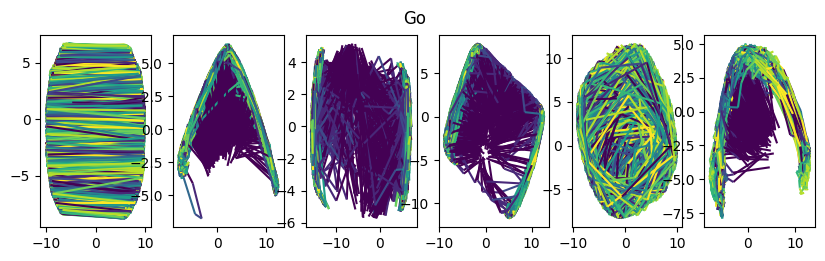

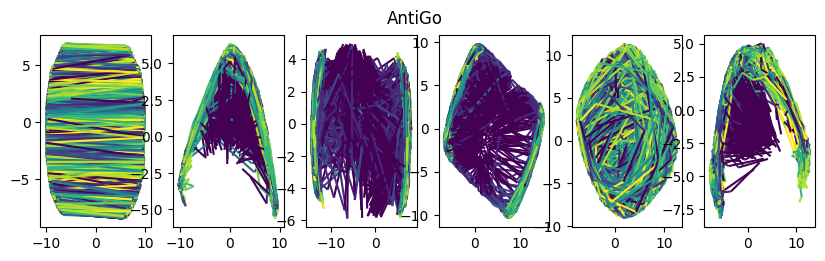

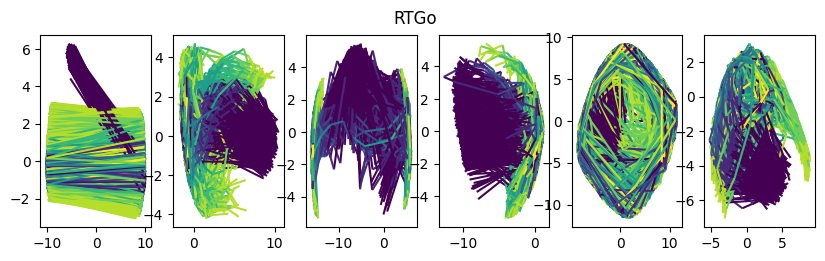

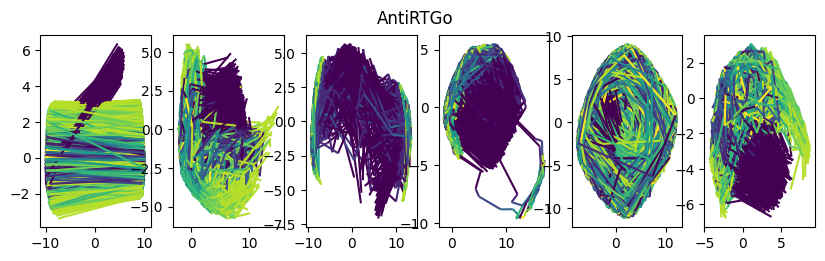

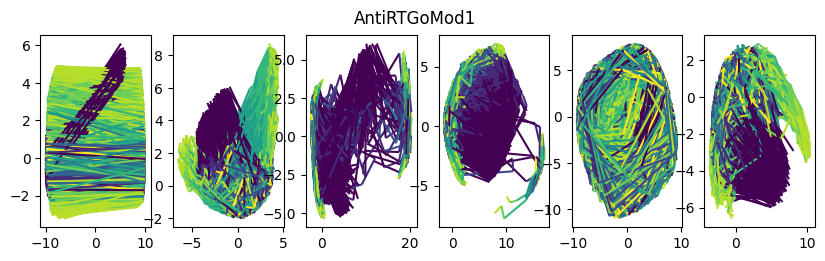

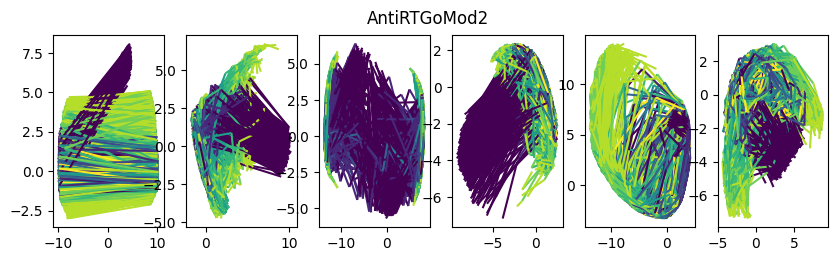

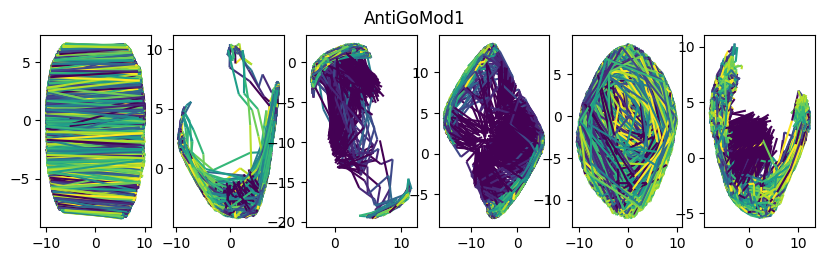

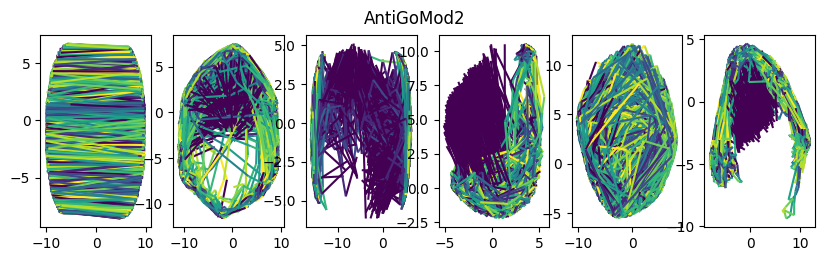

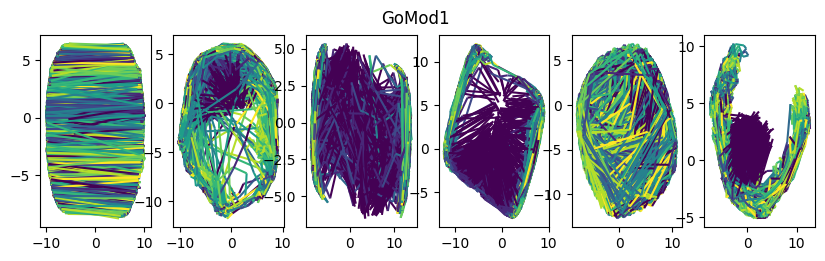

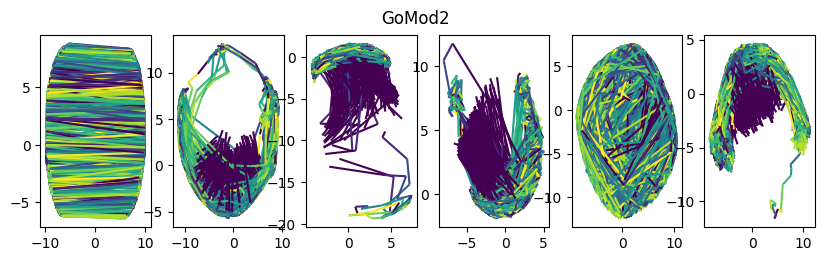

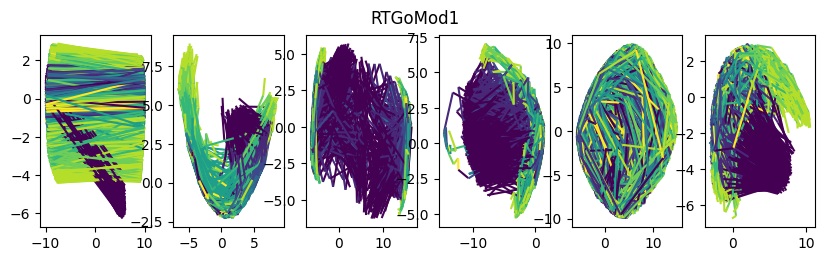

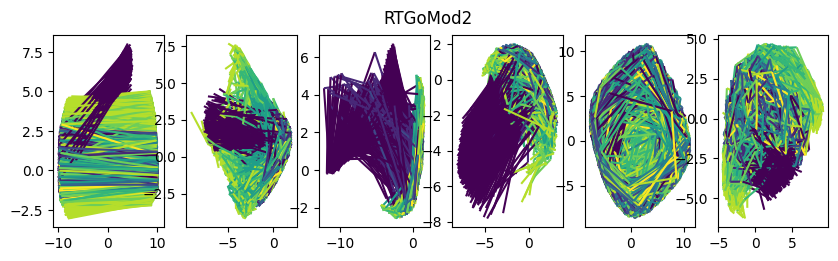

In [9]:
## plot the accuracy per task
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

accuracies = []
accuracy_no_att_task = []

for task_name in tqdm(tasks_names): 

    dataset_task = MultitaskDataset(tasks_names, folder, specific_task=task_name)
    dataloader_task = DataLoader(dataset_task, batch_size=batch_size*10, shuffle=True)

    accuracy_task = []
    for inputs, masks, targets, task_ids in dataloader_task:

        outputs_total,hidden_states,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device))
        labels = torch.argmax(targets.to(device)[:,-1:,:].reshape(-1,output_size),dim=1)

        nb_action = outputs_total.shape[-1]
        output_max = torch.argmax(outputs_total[:,-1:,:].reshape(-1,nb_action),dim=1)
        labels = torch.argmax(targets.to(device)[:,-1:,:].reshape(-1,nb_action),dim=1)
        accuracy = torch.sum((output_max==labels))/len(labels)
        accuracy_task.append(accuracy.item())

        outputs_total_no_att,_,_, _,_ = model(torch.tensor(inputs,dtype=torch.float).to(device),silence_attention=True)
        output_max_no_att = torch.argmax(outputs_total_no_att[:,-1:,:].reshape(-1,nb_action),dim=1)
        accuracy_no_att = torch.sum((output_max_no_att==labels))/len(labels)
        accuracy_no_att_task.append(accuracy_no_att.item())

        h_array = torch.stack(hidden_states).detach().cpu().numpy()
        # print(h_array.shape)
        # Choose a colormap (e.g., 'viridis', 'plasma', 'magma', 'inferno')
        cmap = plt.cm.viridis

        # Convert progression values to RGB colors
        colors = cmap(10)  # Returns RGBA values for each point
        
        # for every module we would like to see the pca space of the hidden states
        f,axs = plt.subplots(1,h_array.shape[2],figsize=(10,2.5))
        for i_mech in range(h_array.shape[2]) :

            ax = axs[i_mech]

            hidden_states_mech = h_array[:,:,i_mech,:]
            hidden_states_mech = hidden_states_mech.reshape(-1,hidden_states_mech.shape[-1])
            hidden_states_mech = hidden_states_mech
            pca = PCA(n_components=2)
            pca.fit(hidden_states_mech)
            h_all = pca.transform(hidden_states_mech)

            for i_trial in range(h_array.shape[1]):
                # get the hidden states of the i_mechanism
                hidden_states_trial = h_array[:,i_trial,i_mech,:]
                pca_h = pca.transform(hidden_states_trial)
                points = np.column_stack((pca_h[:,0], pca_h[:,1]))
                segments = np.array([points[i:i+2] for i in range(len(points)-1)])
                lc = LineCollection(segments, cmap='viridis', array=np.arange(0,1,0.1))
                ax.add_collection(lc)
            
            ax.autoscale()
        f.suptitle(task_name)


        break
        
    accuracies.append(np.mean(accuracy_task))

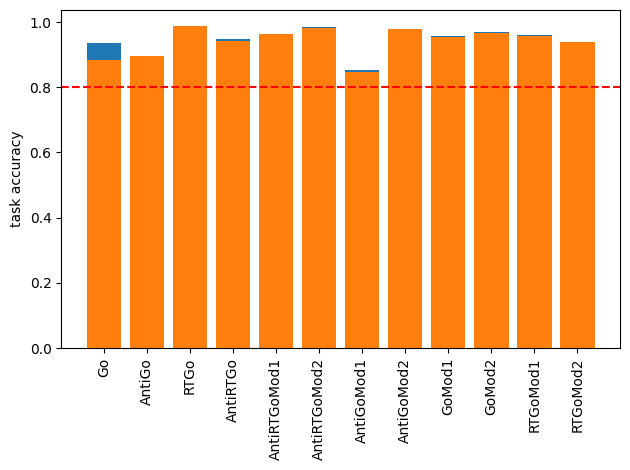

In [10]:
### plot task accuracy
plt.figure()
plt.bar(tasks_names,accuracies)
plt.bar(tasks_names,accuracy_no_att_task)
plt.xticks(rotation=90)
plt.ylabel('task accuracy')
plt.axhline(0.8,color='r',linestyle='--')
plt.tight_layout()
plt.show()